SVM

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


train accuracy:  0.9654989384288747
test accuracy:  0.6883582089552239
f1 score:  0.6883582089552239
train accuracy:  0.9642383227176221
test accuracy:  0.7074626865671642
f1 score:  0.7074626865671642
train accuracy:  0.9651671974522293
test accuracy:  0.702089552238806
f1 score:  0.702089552238806
train accuracy:  0.9644373673036093
test accuracy:  0.706865671641791
f1 score:  0.706865671641791
train accuracy:  0.964968152866242
test accuracy:  0.7080597014925373
f1 score:  0.7080597014925373
train accuracy:  0.964968152866242
test accuracy:  0.6943283582089552
f1 score:  0.6943283582089552
train accuracy:  0.964968152866242
test accuracy:  0.7104477611940299
f1 score:  0.7104477611940299
train accuracy:  0.9649041332183375
test accuracy:  0.6995221027479092
f1 score:  0.6995221027479092
train accuracy:  0.9647714456312612
test accuracy:  0.7198327359617682
f1 score:  0.7198327359617682
train accuracy:  0.9657002587407948
test accuracy:  0.6983273596176822
f1 score:  0.69832735961768

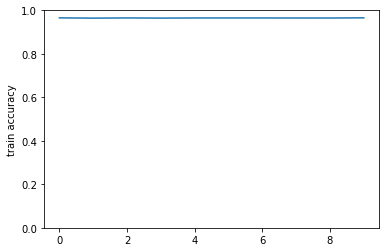

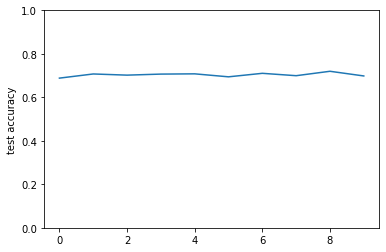

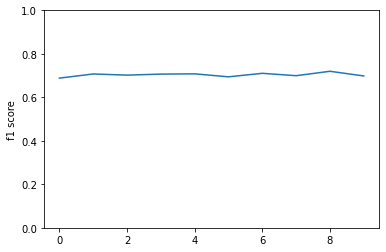

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import string


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter"])
    twitter_score = companies.set_index("Twitter").to_dict()["Performance.Band"]
    tweets["score"] = tweets["user"].map(twitter_score)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "score"]]
    return corpus


def develop_model():
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"], corpus["score"], test_size=0.2)

    kf = KFold(n_splits=10,shuffle=True, random_state = 0)
    kf.split(corpus['content'])

    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    train_acc_list = []
    test_acc_list = []
    f1_score_list = []
 
    # Iterate over each train-test split
    for train_index, test_index in kf.split(corpus['content']):
        # Split train-test
        train_set, test_set = corpus['content'].iloc[train_index], corpus['content'].iloc[test_index]
        train_label, test_label = corpus['score'].iloc[train_index], corpus['score'].iloc[test_index]
    
    
        encoder = LabelEncoder()
        encoder.fit(corpus["score"])
        test_label = encoder.transform(test_label)
        train_label = encoder.transform(train_label)

        tfidf_vect = TfidfVectorizer()
        tfidf_vect.fit(corpus["content"])
        train_set_tfidf = tfidf_vect.transform(train_set)
        test_set_tfidf = tfidf_vect.transform(test_set)

        '''## Standardize the data
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler(with_mean = False)
        # Fit on training set only
        scaler.fit(train_set_tfidf)
        # Apply transform to  training and test sets
        train_set_tfidf = scaler.transform(train_set_tfidf)
        test_set_tfidf = scaler.transform(test_set_tfidf)'''
        

        '''## Apply PCA to reduce dimensionality
        from sklearn.decomposition import PCA
        # Make an instance of the Model with 95% of variance retained
        pca = PCA(.95)
        # Fit to training set only
        pca.fit(train_set_tfidf)
        # Apply transform to training and test sets
        train_set_tfidf = pca.transform(train_set_tfidf)
        test_set_tfidf = pca.transform(test_set_tfidf)'''
        
        '''## Apply Truncated SVD to reduce dimensionality, since PCA didn't work with sparse data
        from sklearn.decomposition import TruncatedSVD
        svd = TruncatedSVD(n_components = 100)
        svd.fit(train_set_tfidf)
        train_set_tfidf = svd.transform(train_set_tfidf)
        test_set_tfidf = svd.transform(test_set_tfidf)'''
        
        
        clf = svm.SVC()
        clf.fit(train_set_tfidf, train_label)
        train_predictions = clf.predict(train_set_tfidf)
        test_predictions = clf.predict(test_set_tfidf)
        
        train_accuracy = accuracy_score(train_predictions, train_label)
        test_accuracy = accuracy_score(test_predictions, test_label)
        f1 = f1_score(test_label, test_predictions, average = 'micro')
        
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        f1_score_list.append(f1)
        
        
        print('train accuracy: ', train_accuracy)
        print('test accuracy: ', test_accuracy)
        print('f1 score: ', f1)
        
        
    
    print('train_avg = ', mean(train_acc_list))
    print('test_avg = ', mean(test_acc_list))
    print('test_avg_f1 = ', mean(f1_score_list))
    
    plt.plot(train_acc_list)
    plt.ylabel('train accuracy')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    plt.plot(test_acc_list)
    plt.ylabel('test accuracy')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    plt.plot(f1_score_list)
    plt.ylabel('f1 score')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    return train_acc_list, test_acc_list, f1_score_list

'''    d = {"content": train_set, "prediction": train_label}
    f = {"content": test_set, "prediction": test_label}
    df = pd.DataFrame(data=d)
    df2 = pd.DataFrame(data=f)
    df = df.append(df2, ignore_index=True)
    tweets_summary = corpus.join(df.set_index("content"), on="content")

    tweets_summary["score"] = encoder.transform(tweets_summary["score"].tolist())
    companies = np.unique(tweets_summary["user"])
    companies_summary = pd.DataFrame(columns=["user", "score", "prediction"])
    for entry in companies:
        company = tweets_summary[tweets_summary["user"] == entry]
        companies_summary = companies_summary.append({"user": entry, "score": company["score"].mode(), "prediction": company["prediction"].mode()}, ignore_index=True)
    print(accuracy_score(np.array(companies_summary["score"].tolist()), np.array(companies_summary["prediction"].tolist())))

    tweets_summary["score"] = encoder.inverse_transform(tweets_summary["score"].tolist())
    tweets_summary["prediction"] = encoder.inverse_transform(tweets_summary["prediction"].tolist())
    companies_summary["score"] = encoder.inverse_transform(companies_summary["score"].tolist())
    companies_summary["prediction"] = encoder.inverse_transform(companies_summary["prediction"].tolist())

    tweets_summary.to_csv("tweets_summary.csv")
    companies_summary.to_csv("companies_summary.csv")'''
    

def main():
    train_acc_list, test_acc_list, f1_score_list = develop_model()
    return train_acc_list, test_acc_list, f1_score_list


if __name__ == '__main__':
    train_acc_list, test_acc_list, f1_score_list = main()

SVM + standard scaler + PCA
(Doesn't work)

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import string


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter"])
    twitter_score = companies.set_index("Twitter").to_dict()["Performance.Band"]
    tweets["score"] = tweets["user"].map(twitter_score)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "score"]]
    return corpus


def develop_model():
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"], corpus["score"], test_size=0.2)

    kf = KFold(n_splits=10,shuffle=True, random_state = 0)
    kf.split(corpus['content'])

    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    train_acc_list = []
    test_acc_list = []
    f1_score_list = []
 
    # Iterate over each train-test split
    for train_index, test_index in kf.split(corpus['content']):
        # Split train-test
        train_set, test_set = corpus['content'].iloc[train_index], corpus['content'].iloc[test_index]
        train_label, test_label = corpus['score'].iloc[train_index], corpus['score'].iloc[test_index]
    
    
        encoder = LabelEncoder()
        encoder.fit(corpus["score"])
        test_label = encoder.transform(test_label)
        train_label = encoder.transform(train_label)

        tfidf_vect = TfidfVectorizer()
        tfidf_vect.fit(corpus["content"])
        train_set_tfidf = tfidf_vect.transform(train_set)
        test_set_tfidf = tfidf_vect.transform(test_set)

        ## Standardize the data
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler(with_mean = False)
        # Fit on training set only
        scaler.fit(train_set_tfidf)
        # Apply transform to  training and test sets
        train_set_tfidf = scaler.transform(train_set_tfidf)
        test_set_tfidf = scaler.transform(test_set_tfidf)
        

        ## Apply PCA to reduce dimensionality
        from sklearn.decomposition import PCA
        # Make an instance of the Model with 95% of variance retained
        pca = PCA(.95)
        # Fit to training set only
        pca.fit(train_set_tfidf)
        # Apply transform to training and test sets
        train_set_tfidf = pca.transform(train_set_tfidf)
        test_set_tfidf = pca.transform(test_set_tfidf)
        
        '''## Apply Truncated SVD to reduce dimensionality, since PCA didn't work with sparse data
        from sklearn.decomposition import TruncatedSVD
        svd = TruncatedSVD(n_components = 100)
        svd.fit(train_set_tfidf)
        train_set_tfidf = svd.transform(train_set_tfidf)
        test_set_tfidf = svd.transform(test_set_tfidf)'''
        
        
        clf = svm.SVC()
        clf.fit(train_set_tfidf, train_label)
        train_predictions = clf.predict(train_set_tfidf)
        test_predictions = clf.predict(test_set_tfidf)
        
        train_accuracy = accuracy_score(train_predictions, train_label)
        test_accuracy = accuracy_score(test_predictions, test_label)
        f1 = f1_score(test_label, test_predictions, average = 'micro')
        
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        f1_score_list.append(f1)
        
        
        print('train accuracy: ', train_accuracy)
        print('test accuracy: ', test_accuracy)
        print('f1 score: ', f1)
        
        
    
    print('train_avg = ', mean(train_acc_list))
    print('test_avg = ', mean(test_acc_list))
    print('test_avg_f1 = ', mean(f1_score_list))
    
    plt.plot(train_acc_list)
    plt.ylabel('train accuracy')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    plt.plot(test_acc_list)
    plt.ylabel('test accuracy')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    plt.plot(f1_score_list)
    plt.ylabel('f1 score')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    return train_acc_list, test_acc_list, f1_score_list

'''    d = {"content": train_set, "prediction": train_label}
    f = {"content": test_set, "prediction": test_label}
    df = pd.DataFrame(data=d)
    df2 = pd.DataFrame(data=f)
    df = df.append(df2, ignore_index=True)
    tweets_summary = corpus.join(df.set_index("content"), on="content")

    tweets_summary["score"] = encoder.transform(tweets_summary["score"].tolist())
    companies = np.unique(tweets_summary["user"])
    companies_summary = pd.DataFrame(columns=["user", "score", "prediction"])
    for entry in companies:
        company = tweets_summary[tweets_summary["user"] == entry]
        companies_summary = companies_summary.append({"user": entry, "score": company["score"].mode(), "prediction": company["prediction"].mode()}, ignore_index=True)
    print(accuracy_score(np.array(companies_summary["score"].tolist()), np.array(companies_summary["prediction"].tolist())))

    tweets_summary["score"] = encoder.inverse_transform(tweets_summary["score"].tolist())
    tweets_summary["prediction"] = encoder.inverse_transform(tweets_summary["prediction"].tolist())
    companies_summary["score"] = encoder.inverse_transform(companies_summary["score"].tolist())
    companies_summary["prediction"] = encoder.inverse_transform(companies_summary["prediction"].tolist())

    tweets_summary.to_csv("tweets_summary.csv")
    companies_summary.to_csv("companies_summary.csv")'''
    

def main():
    train_acc_list, test_acc_list, f1_score_list = develop_model()
    return train_acc_list, test_acc_list, f1_score_list


if __name__ == '__main__':
    train_acc_list, test_acc_list, f1_score_list = main()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

SVM + truncated SVD

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


train accuracy:  0.6222133757961783
test accuracy:  0.5104477611940299
f1 score:  0.5104477611940299
train accuracy:  0.6220806794055201
test accuracy:  0.5576119402985075
f1 score:  0.5576119402985075
train accuracy:  0.6167728237791932
test accuracy:  0.5522388059701493
f1 score:  0.5522388059701493
train accuracy:  0.6165074309978769
test accuracy:  0.5343283582089552
f1 score:  0.5343283582089552
train accuracy:  0.6191613588110403
test accuracy:  0.5504477611940298
f1 score:  0.5504477611940298
train accuracy:  0.6164410828025477
test accuracy:  0.5313432835820896
f1 score:  0.5313432835820896
train accuracy:  0.6205546709129511
test accuracy:  0.5552238805970149
f1 score:  0.5552238805970149
train accuracy:  0.6162674981755457
test accuracy:  0.5328554360812425
f1 score:  0.5328554360812425
train accuracy:  0.6156040602401646
test accuracy:  0.5639187574671446
f1 score:  0.5639187574671446
train accuracy:  0.6186558747429178
test accuracy:  0.5221027479091995
f1 score:  0.5221027

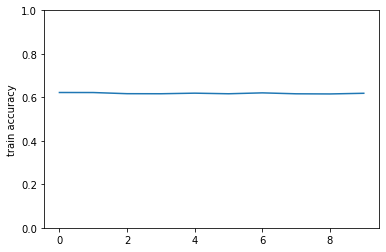

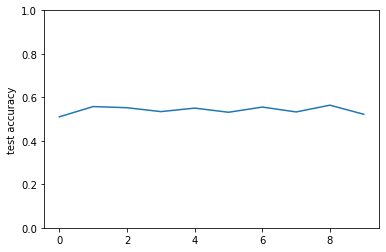

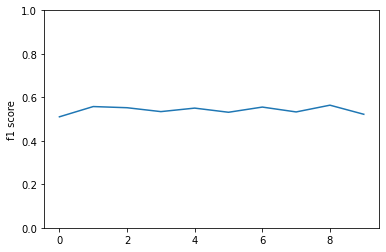

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import string


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter"])
    twitter_score = companies.set_index("Twitter").to_dict()["Performance.Band"]
    tweets["score"] = tweets["user"].map(twitter_score)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "score"]]
    return corpus


def develop_model():
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"], corpus["score"], test_size=0.2)

    kf = KFold(n_splits=10,shuffle=True, random_state = 0)
    kf.split(corpus['content'])

    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    train_acc_list = []
    test_acc_list = []
    f1_score_list = []
 
    # Iterate over each train-test split
    for train_index, test_index in kf.split(corpus['content']):
        # Split train-test
        train_set, test_set = corpus['content'].iloc[train_index], corpus['content'].iloc[test_index]
        train_label, test_label = corpus['score'].iloc[train_index], corpus['score'].iloc[test_index]
    
    
        encoder = LabelEncoder()
        encoder.fit(corpus["score"])
        test_label = encoder.transform(test_label)
        train_label = encoder.transform(train_label)

        tfidf_vect = TfidfVectorizer()
        tfidf_vect.fit(corpus["content"])
        train_set_tfidf = tfidf_vect.transform(train_set)
        test_set_tfidf = tfidf_vect.transform(test_set)

        '''## Standardize the data
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler(with_mean = False)
        # Fit on training set only
        scaler.fit(train_set_tfidf)
        # Apply transform to  training and test sets
        train_set_tfidf = scaler.transform(train_set_tfidf)
        test_set_tfidf = scaler.transform(test_set_tfidf)'''
        

        '''## Apply PCA to reduce dimensionality
        from sklearn.decomposition import PCA
        # Make an instance of the Model with 95% of variance retained
        pca = PCA(.95)
        # Fit to training set only
        pca.fit(train_set_tfidf)
        # Apply transform to training and test sets
        train_set_tfidf = pca.transform(train_set_tfidf)
        test_set_tfidf = pca.transform(test_set_tfidf)'''
        
        ## Apply Truncated SVD to reduce dimensionality, since PCA didn't work with sparse data
        from sklearn.decomposition import TruncatedSVD
        svd = TruncatedSVD(n_components = 100)
        svd.fit(train_set_tfidf)
        train_set_tfidf = svd.transform(train_set_tfidf)
        test_set_tfidf = svd.transform(test_set_tfidf)
        
        
        clf = svm.SVC()
        clf.fit(train_set_tfidf, train_label)
        train_predictions = clf.predict(train_set_tfidf)
        test_predictions = clf.predict(test_set_tfidf)
        
        train_accuracy = accuracy_score(train_predictions, train_label)
        test_accuracy = accuracy_score(test_predictions, test_label)
        f1 = f1_score(test_label, test_predictions, average = 'micro')
        
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        f1_score_list.append(f1)
        
        
        print('train accuracy: ', train_accuracy)
        print('test accuracy: ', test_accuracy)
        print('f1 score: ', f1)
        
        
    
    print('train_avg = ', mean(train_acc_list))
    print('test_avg = ', mean(test_acc_list))
    print('test_avg_f1 = ', mean(f1_score_list))
    
    plt.plot(train_acc_list)
    plt.ylabel('train accuracy')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    plt.plot(test_acc_list)
    plt.ylabel('test accuracy')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    plt.plot(f1_score_list)
    plt.ylabel('f1 score')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    return train_acc_list, test_acc_list, f1_score_list

'''    d = {"content": train_set, "prediction": train_label}
    f = {"content": test_set, "prediction": test_label}
    df = pd.DataFrame(data=d)
    df2 = pd.DataFrame(data=f)
    df = df.append(df2, ignore_index=True)
    tweets_summary = corpus.join(df.set_index("content"), on="content")

    tweets_summary["score"] = encoder.transform(tweets_summary["score"].tolist())
    companies = np.unique(tweets_summary["user"])
    companies_summary = pd.DataFrame(columns=["user", "score", "prediction"])
    for entry in companies:
        company = tweets_summary[tweets_summary["user"] == entry]
        companies_summary = companies_summary.append({"user": entry, "score": company["score"].mode(), "prediction": company["prediction"].mode()}, ignore_index=True)
    print(accuracy_score(np.array(companies_summary["score"].tolist()), np.array(companies_summary["prediction"].tolist())))

    tweets_summary["score"] = encoder.inverse_transform(tweets_summary["score"].tolist())
    tweets_summary["prediction"] = encoder.inverse_transform(tweets_summary["prediction"].tolist())
    companies_summary["score"] = encoder.inverse_transform(companies_summary["score"].tolist())
    companies_summary["prediction"] = encoder.inverse_transform(companies_summary["prediction"].tolist())

    tweets_summary.to_csv("tweets_summary.csv")
    companies_summary.to_csv("companies_summary.csv")'''
    

def main():
    train_acc_list, test_acc_list, f1_score_list = develop_model()
    return train_acc_list, test_acc_list, f1_score_list


if __name__ == '__main__':
    train_acc_list, test_acc_list, f1_score_list = main()

Random Forest

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


train accuracy:  0.9877255838641189
test accuracy:  0.7337313432835821
f1 score:  0.7337313432835822
train accuracy:  0.9869294055201698
test accuracy:  0.7408955223880597
f1 score:  0.7408955223880596
train accuracy:  0.9877255838641189
test accuracy:  0.7408955223880597
f1 score:  0.7408955223880596
train accuracy:  0.9871284501061571
test accuracy:  0.7438805970149254
f1 score:  0.7438805970149254
train accuracy:  0.9874601910828026
test accuracy:  0.7259701492537314
f1 score:  0.7259701492537313
train accuracy:  0.9871284501061571
test accuracy:  0.7205970149253731
f1 score:  0.7205970149253731
train accuracy:  0.9869294055201698
test accuracy:  0.7474626865671642
f1 score:  0.7474626865671642
train accuracy:  0.9875937106083725
test accuracy:  0.7210274790919953
f1 score:  0.7210274790919953
train accuracy:  0.9873283354342202
test accuracy:  0.7604540023894862
f1 score:  0.7604540023894862
train accuracy:  0.9877927419889869
test accuracy:  0.7258064516129032
f1 score:  0.7258064

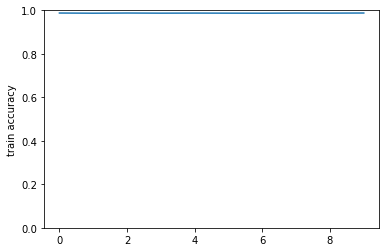

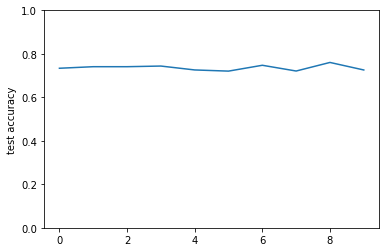

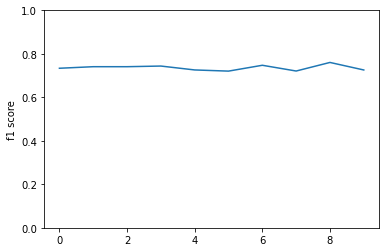

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean

from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import string

from sklearn.ensemble import RandomForestClassifier


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter"])
    twitter_score = companies.set_index("Twitter").to_dict()["Performance.Band"]
    tweets["score"] = tweets["user"].map(twitter_score)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "score"]]
    return corpus


def develop_model():
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"], corpus["score"], test_size=0.2)

    kf = KFold(n_splits=10,shuffle=True, random_state = 0)
    kf.split(corpus['content'])

    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    train_acc_list = []
    test_acc_list = []
    f1_score_list = []
 
    # Iterate over each train-test split
    for train_index, test_index in kf.split(corpus['content']):
        # Split train-test
        train_set, test_set = corpus['content'].iloc[train_index], corpus['content'].iloc[test_index]
        train_label, test_label = corpus['score'].iloc[train_index], corpus['score'].iloc[test_index]
    
    
        encoder = LabelEncoder()
        encoder.fit(corpus["score"])
        test_label = encoder.transform(test_label)
        train_label = encoder.transform(train_label)

        tfidf_vect = TfidfVectorizer()
        tfidf_vect.fit(corpus["content"])
        train_set_tfidf = tfidf_vect.transform(train_set)
        test_set_tfidf = tfidf_vect.transform(test_set)

        clf = RandomForestClassifier()
        clf.fit(train_set_tfidf, train_label)
        train_predictions = clf.predict(train_set_tfidf)
        test_predictions = clf.predict(test_set_tfidf)
        
        train_accuracy = accuracy_score(train_predictions, train_label)
        test_accuracy = accuracy_score(test_predictions, test_label)
        f1 = f1_score(test_label, test_predictions, average = 'micro')
        
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        f1_score_list.append(f1)
        
        print('train accuracy: ', train_accuracy)
        print('test accuracy: ', test_accuracy)
        print('f1 score: ', f1)
    
    
    print('train_avg = ', mean(train_acc_list))
    print('test_avg = ', mean(test_acc_list))
    print('test_avg_f1 = ', mean(f1_score_list))
    
    plt.plot(train_acc_list)
    plt.ylabel('train accuracy')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    plt.plot(test_acc_list)
    plt.ylabel('test accuracy')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    plt.plot(f1_score_list)
    plt.ylabel('f1 score')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    return train_acc_list, test_acc_list, f1_score_list

'''    d = {"content": train_set, "prediction": train_label}
    f = {"content": test_set, "prediction": test_label}
    df = pd.DataFrame(data=d)
    df2 = pd.DataFrame(data=f)
    df = df.append(df2, ignore_index=True)
    tweets_summary = corpus.join(df.set_index("content"), on="content")

    tweets_summary["score"] = encoder.transform(tweets_summary["score"].tolist())
    companies = np.unique(tweets_summary["user"])
    companies_summary = pd.DataFrame(columns=["user", "score", "prediction"])
    for entry in companies:
        company = tweets_summary[tweets_summary["user"] == entry]
        companies_summary = companies_summary.append({"user": entry, "score": company["score"].mode(), "prediction": company["prediction"].mode()}, ignore_index=True)
    print(accuracy_score(np.array(companies_summary["score"].tolist()), np.array(companies_summary["prediction"].tolist())))

    tweets_summary["score"] = encoder.inverse_transform(tweets_summary["score"].tolist())
    tweets_summary["prediction"] = encoder.inverse_transform(tweets_summary["prediction"].tolist())
    companies_summary["score"] = encoder.inverse_transform(companies_summary["score"].tolist())
    companies_summary["prediction"] = encoder.inverse_transform(companies_summary["prediction"].tolist())

    tweets_summary.to_csv("tweets_summary.csv")
    companies_summary.to_csv("companies_summary.csv")'''


def main():
    train_acc_list, test_acc_list, f1_score_list = develop_model()
    return train_acc_list, test_acc_list, f1_score_list


if __name__ == '__main__':
    train_acc_list, test_acc_list, f1_score_list = main()


Random Forest + standard scaler + PCA
(Doesn't work)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean

from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import string

from sklearn.ensemble import RandomForestClassifier


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter"])
    twitter_score = companies.set_index("Twitter").to_dict()["Performance.Band"]
    tweets["score"] = tweets["user"].map(twitter_score)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "score"]]
    return corpus


def develop_model():
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"], corpus["score"], test_size=0.2)

    kf = KFold(n_splits=10,shuffle=True, random_state = 0)
    kf.split(corpus['content'])

    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    train_acc_list = []
    test_acc_list = []
    f1_score_list = []
 
    # Iterate over each train-test split
    for train_index, test_index in kf.split(corpus['content']):
        # Split train-test
        train_set, test_set = corpus['content'].iloc[train_index], corpus['content'].iloc[test_index]
        train_label, test_label = corpus['score'].iloc[train_index], corpus['score'].iloc[test_index]
    
    
        encoder = LabelEncoder()
        encoder.fit(corpus["score"])
        test_label = encoder.transform(test_label)
        train_label = encoder.transform(train_label)

        tfidf_vect = TfidfVectorizer()
        tfidf_vect.fit(corpus["content"])
        train_set_tfidf = tfidf_vect.transform(train_set)
        test_set_tfidf = tfidf_vect.transform(test_set)
        
        ## Standardize the data
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler(with_mean = False)
        # Fit on training set only
        scaler.fit(train_set_tfidf)
        # Apply transform to  training and test sets
        train_set_tfidf = scaler.transform(train_set_tfidf)
        test_set_tfidf = scaler.transform(test_set_tfidf)
        

        ## Apply PCA to reduce dimensionality
        from sklearn.decomposition import PCA
        # Make an instance of the Model with 95% of variance retained
        pca = PCA(.95)
        # Fit to training set only
        pca.fit(train_set_tfidf)
        # Apply transform to training and test sets
        train_set_tfidf = pca.transform(train_set_tfidf)
        test_set_tfidf = pca.transform(test_set_tfidf)
        
        '''## Apply Truncated SVD to reduce dimensionality, since PCA didn't work with sparse data
        from sklearn.decomposition import TruncatedSVD
        svd = TruncatedSVD(n_components = 100)
        svd.fit(train_set_tfidf)
        train_set_tfidf = svd.transform(train_set_tfidf)
        test_set_tfidf = svd.transform(test_set_tfidf)'''

        clf = RandomForestClassifier()
        clf.fit(train_set_tfidf, train_label)
        train_predictions = clf.predict(train_set_tfidf)
        test_predictions = clf.predict(test_set_tfidf)
        
        train_accuracy = accuracy_score(train_predictions, train_label)
        test_accuracy = accuracy_score(test_predictions, test_label)
        f1 = f1_score(test_label, test_predictions, average = 'micro')
        
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        f1_score_list.append(f1)
        
        print('train accuracy: ', train_accuracy)
        print('test accuracy: ', test_accuracy)
        print('f1 score: ', f1)
    
    
    print('train_avg = ', mean(train_acc_list))
    print('test_avg = ', mean(test_acc_list))
    print('test_avg_f1 = ', mean(f1_score_list))
    
    plt.plot(train_acc_list)
    plt.ylabel('train accuracy')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    plt.plot(test_acc_list)
    plt.ylabel('test accuracy')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    plt.plot(f1_score_list)
    plt.ylabel('f1 score')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    return train_acc_list, test_acc_list, f1_score_list

'''    d = {"content": train_set, "prediction": train_label}
    f = {"content": test_set, "prediction": test_label}
    df = pd.DataFrame(data=d)
    df2 = pd.DataFrame(data=f)
    df = df.append(df2, ignore_index=True)
    tweets_summary = corpus.join(df.set_index("content"), on="content")

    tweets_summary["score"] = encoder.transform(tweets_summary["score"].tolist())
    companies = np.unique(tweets_summary["user"])
    companies_summary = pd.DataFrame(columns=["user", "score", "prediction"])
    for entry in companies:
        company = tweets_summary[tweets_summary["user"] == entry]
        companies_summary = companies_summary.append({"user": entry, "score": company["score"].mode(), "prediction": company["prediction"].mode()}, ignore_index=True)
    print(accuracy_score(np.array(companies_summary["score"].tolist()), np.array(companies_summary["prediction"].tolist())))

    tweets_summary["score"] = encoder.inverse_transform(tweets_summary["score"].tolist())
    tweets_summary["prediction"] = encoder.inverse_transform(tweets_summary["prediction"].tolist())
    companies_summary["score"] = encoder.inverse_transform(companies_summary["score"].tolist())
    companies_summary["prediction"] = encoder.inverse_transform(companies_summary["prediction"].tolist())

    tweets_summary.to_csv("tweets_summary.csv")
    companies_summary.to_csv("companies_summary.csv")'''


def main():
    train_acc_list, test_acc_list, f1_score_list = develop_model()
    return train_acc_list, test_acc_list, f1_score_list


if __name__ == '__main__':
    train_acc_list, test_acc_list, f1_score_list = main()


Random Forest + Truncated SVD

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


train accuracy:  0.9871284501061571
test accuracy:  0.5188059701492538
f1 score:  0.5188059701492538
train accuracy:  0.9861332271762208
test accuracy:  0.537910447761194
f1 score:  0.537910447761194
train accuracy:  0.9871284501061571
test accuracy:  0.5498507462686567
f1 score:  0.5498507462686567
train accuracy:  0.9861995753715499
test accuracy:  0.5444776119402985
f1 score:  0.5444776119402985
train accuracy:  0.9865976645435244
test accuracy:  0.5462686567164179
f1 score:  0.5462686567164179
train accuracy:  0.9861995753715499
test accuracy:  0.5361194029850747
f1 score:  0.5361194029850747
train accuracy:  0.986265923566879
test accuracy:  0.5480597014925374
f1 score:  0.5480597014925374
train accuracy:  0.9871293040536058
test accuracy:  0.5328554360812425
f1 score:  0.5328554360812425
train accuracy:  0.9863331785311484
test accuracy:  0.5645161290322581
f1 score:  0.5645161290322581
train accuracy:  0.9874610230212963
test accuracy:  0.5149342891278376
f1 score:  0.5149342891

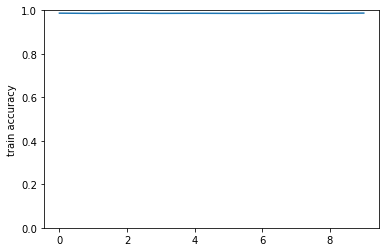

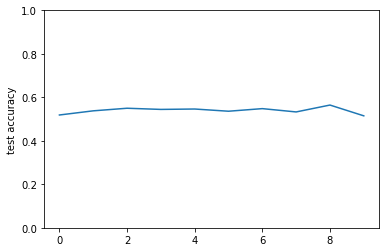

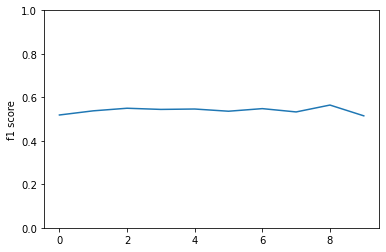

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean

from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import string

from sklearn.ensemble import RandomForestClassifier


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter"])
    twitter_score = companies.set_index("Twitter").to_dict()["Performance.Band"]
    tweets["score"] = tweets["user"].map(twitter_score)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "score"]]
    return corpus


def develop_model():
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"], corpus["score"], test_size=0.2)

    kf = KFold(n_splits=10,shuffle=True, random_state = 0)
    kf.split(corpus['content'])

    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    train_acc_list = []
    test_acc_list = []
    f1_score_list = []
 
    # Iterate over each train-test split
    for train_index, test_index in kf.split(corpus['content']):
        # Split train-test
        train_set, test_set = corpus['content'].iloc[train_index], corpus['content'].iloc[test_index]
        train_label, test_label = corpus['score'].iloc[train_index], corpus['score'].iloc[test_index]
    
    
        encoder = LabelEncoder()
        encoder.fit(corpus["score"])
        test_label = encoder.transform(test_label)
        train_label = encoder.transform(train_label)

        tfidf_vect = TfidfVectorizer()
        tfidf_vect.fit(corpus["content"])
        train_set_tfidf = tfidf_vect.transform(train_set)
        test_set_tfidf = tfidf_vect.transform(test_set)
        
        '''## Standardize the data
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler(with_mean = False)
        # Fit on training set only
        scaler.fit(train_set_tfidf)
        # Apply transform to  training and test sets
        train_set_tfidf = scaler.transform(train_set_tfidf)
        test_set_tfidf = scaler.transform(test_set_tfidf)'''
        

        '''## Apply PCA to reduce dimensionality
        from sklearn.decomposition import PCA
        # Make an instance of the Model with 95% of variance retained
        pca = PCA(.95)
        # Fit to training set only
        pca.fit(train_set_tfidf)
        # Apply transform to training and test sets
        train_set_tfidf = pca.transform(train_set_tfidf)
        test_set_tfidf = pca.transform(test_set_tfidf)'''
        
        ## Apply Truncated SVD to reduce dimensionality, since PCA didn't work with sparse data
        from sklearn.decomposition import TruncatedSVD
        svd = TruncatedSVD(n_components = 100)
        svd.fit(train_set_tfidf)
        train_set_tfidf = svd.transform(train_set_tfidf)
        test_set_tfidf = svd.transform(test_set_tfidf)

        clf = RandomForestClassifier()
        clf.fit(train_set_tfidf, train_label)
        train_predictions = clf.predict(train_set_tfidf)
        test_predictions = clf.predict(test_set_tfidf)
        
        train_accuracy = accuracy_score(train_predictions, train_label)
        test_accuracy = accuracy_score(test_predictions, test_label)
        f1 = f1_score(test_label, test_predictions, average = 'micro')
        
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        f1_score_list.append(f1)
        
        print('train accuracy: ', train_accuracy)
        print('test accuracy: ', test_accuracy)
        print('f1 score: ', f1)
    
    
    print('train_avg = ', mean(train_acc_list))
    print('test_avg = ', mean(test_acc_list))
    print('test_avg_f1 = ', mean(f1_score_list))
    
    plt.plot(train_acc_list)
    plt.ylabel('train accuracy')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    plt.plot(test_acc_list)
    plt.ylabel('test accuracy')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    plt.plot(f1_score_list)
    plt.ylabel('f1 score')
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()
    
    return train_acc_list, test_acc_list, f1_score_list

'''    d = {"content": train_set, "prediction": train_label}
    f = {"content": test_set, "prediction": test_label}
    df = pd.DataFrame(data=d)
    df2 = pd.DataFrame(data=f)
    df = df.append(df2, ignore_index=True)
    tweets_summary = corpus.join(df.set_index("content"), on="content")

    tweets_summary["score"] = encoder.transform(tweets_summary["score"].tolist())
    companies = np.unique(tweets_summary["user"])
    companies_summary = pd.DataFrame(columns=["user", "score", "prediction"])
    for entry in companies:
        company = tweets_summary[tweets_summary["user"] == entry]
        companies_summary = companies_summary.append({"user": entry, "score": company["score"].mode(), "prediction": company["prediction"].mode()}, ignore_index=True)
    print(accuracy_score(np.array(companies_summary["score"].tolist()), np.array(companies_summary["prediction"].tolist())))

    tweets_summary["score"] = encoder.inverse_transform(tweets_summary["score"].tolist())
    tweets_summary["prediction"] = encoder.inverse_transform(tweets_summary["prediction"].tolist())
    companies_summary["score"] = encoder.inverse_transform(companies_summary["score"].tolist())
    companies_summary["prediction"] = encoder.inverse_transform(companies_summary["prediction"].tolist())

    tweets_summary.to_csv("tweets_summary.csv")
    companies_summary.to_csv("companies_summary.csv")'''


def main():
    train_acc_list, test_acc_list, f1_score_list = develop_model()
    return train_acc_list, test_acc_list, f1_score_list


if __name__ == '__main__':
    train_acc_list, test_acc_list, f1_score_list = main()
